In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read Data

In [2]:
test = pd.read_csv("../data/test.csv")
true = np.array(test[test['weekID']>=90]['outcome']).reshape(392,5)

with open('../data/test_preds.p', 'rb') as f:
    preds = pickle.load(f)
    
preds = preds.squeeze()
num_preds = preds.shape[0]*preds.shape[1]

preds.shape

(392, 5)

## Evaluate Frobenius Norm 
(L2 error over all units and time steps)

### Log predictions

In [3]:
frob_norm_log = np.sqrt(np.sum((preds - np.log(1+true))**2)/num_preds)
frob_norm_log

3.0804402169114

### Raw predictions

In [4]:
preds_raw = np.exp(preds.squeeze()) - 1
frob_norm_raw = np.sqrt(np.sum((preds_raw - true)**2)/num_preds)
frob_norm_raw

116.241633961796

/Users/sargunnagpal/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


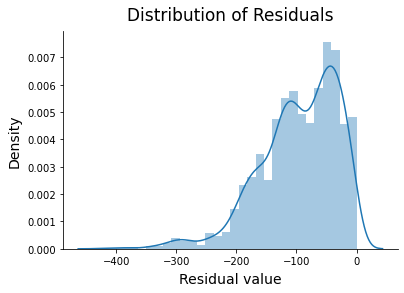

In [5]:
residuals = (true - preds_raw).flatten()

plt.figure(figsize=(6,4))
sns.distplot(residuals)
plt.xlabel(r"Residual value", fontsize=14, labelpad=6)
plt.ylabel("Density", fontsize=14, labelpad=6)
plt.title("Distribution of Residuals", size=17, pad=11)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# plt.legend(frameon=False)
plt.show()

Squared error penalizes outliers heavily. The high density at 0 reveals that most predictions are close to the ground truth. However, some predictions are extremely wrong (right tail).

In [6]:
clipped_residuals = residuals[residuals > np.percentile(residuals, 10)]
np.sqrt(np.sum(clipped_residuals**2)/num_preds)

89.53693129416392

## Error Analysis (To Do)

# Inference Data

### Data submission preparation (ACIC)

In [7]:
with open('../data/infer_preds.p', 'rb') as f:
    infer_preds = pickle.load(f)

sample_preds = pd.read_csv('../data/sample_predictions.csv')

infer_preds.shape

(23448, 5, 1)

In [8]:
units = np.sort(sample_preds['unitID'].unique())
pred_df = pd.DataFrame()

for i in range(len(units)):
    start = 6*i
    end = start+6
    data = pd.DataFrame(infer_preds[start:end].squeeze().T, 
                 columns=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    data['unitID'] = units[i]
    data['step'] = list(range(1,6))
    pred_df = pd.concat([pred_df, data], axis=0, ignore_index=True)

In [9]:
pred_df = sample_preds[['unitID', 'step']].merge(pred_df, on=['unitID', 'step'])
pred_df = pred_df[[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 'unitID', 'step']]
pred_df

,0.0,0.1,0.2,0.3,0.4,0.5,unitID,step
0,6.107857,6.107857,6.107857,6.107857,6.107857,6.107857,UNIT01155,1
1,6.750155,6.616137,6.614773,6.533853,6.510631,6.379734,UNIT01155,2
2,6.771299,6.455389,6.571820,6.546522,6.422444,6.366980,UNIT01155,3
3,6.810244,6.401143,6.649715,6.673573,6.542608,6.478425,UNIT01155,4
4,6.796067,6.501856,6.652357,6.714709,6.585715,6.498622,UNIT01155,5
...,...,...,...,...,...,...,...,...
19535,6.427546,6.427546,6.427546,6.427546,6.427546,6.427546,UNIT04556,1
19536,6.564068,6.421980,6.454550,6.418807,6.468501,6.392307,UNIT04556,2
19537,6.651685,6.287034,6.498382,6.428701,6.307170,6.294010,UNIT04556,3
19538,6.609976,6.268872,6.469276,6.580008,6.452143,6.310002,UNIT04556,4


In [10]:
pred_df.to_csv("../data/acic_submission.csv", index=False)